In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import pprint
import zipfile
import seaborn as sns;sns.set(color_codes=True)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer

In [2]:
#Notebook lavel configurations
warnings.filterwarnings('ignore')
pp = pprint.PrettyPrinter(indent=4)

In [3]:
input_dir = 'input.nosync'

In [4]:
# Read application_train.csv
app_train = pd.read_csv(input_dir+'/application_train.csv')
app_test = pd.read_csv(input_dir+'/application_test.csv')
print('Training data shape: ', app_train.shape)
print('Test data shape: ', app_test.shape)
app_train.head()

Training data shape:  (307511, 122)
Test data shape:  (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


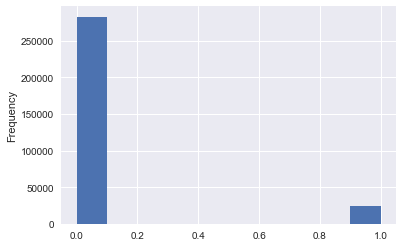

In [5]:
app_train['TARGET'].value_counts()
app_train['TARGET'].plot.hist()

In [6]:
# function to calculate missing values by column
def missing_value_df(df):
    # total missing values
    mis_val = df.isnull().sum()
    
    # percentage of missing values
    mis_val_percent = 100*mis_val/len(df)
    
    # make a table with results
    mis_val_df = pd.concat([mis_val, mis_val_percent], axis = 1)
    
    #rename the columns
    mis_val_df_rename = mis_val_df.rename(columns = {0: 'Missing Data', 1: '% of Total Data'})
    
    #sort the table in descending order of percentage
    mis_val_df_rename = mis_val_df_rename[mis_val_df_rename.iloc[:,1]!= 0].sort_values('% of Total Data', ascending=False).round(1)
    print (f"Total DataFrame Columns is {df.shape[1]}")
    print(f"Number of Columns missing data{mis_val_df_rename.shape[0]}")
    return mis_val_df_rename
                                

In [7]:
#missing value stats
missing_val_column = missing_value_df(app_train)
missing_val_column.head(5)

Total DataFrame Columns is 122
Number of Columns missing data67


,Missing Data,% of Total Data
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


In [8]:
# inspecting data types of columns
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
# one hot-encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: {app_train.shape}')
print('Testing Features shape:{app_test.shape}')

Training Features shape: {app_train.shape}
Testing Features shape:{app_test.shape}


In [10]:
# since in the DAYS_BIRTH and DAYS_EMPLOYED column days are calculated realtive to loan
print((app_train['DAYS_BIRTH']/-365).describe())


print((app_train['DAYS_EMPLOYED']).describe())

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64
count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


The Max amount for DAYS_EMPLOYED is 365243 which is incorrect and should be a outlier as the histgoram shows below

Text(0.5,0,'Days Employment')

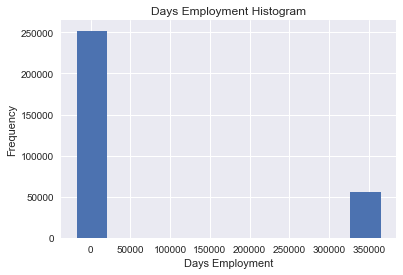

In [11]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

for deeper understand the DAYS_EMPLOYED information, we need to check 
the "normal"vs"non-normal" people's default rate

In [12]:
non_nom = app_train[app_train["DAYS_EMPLOYED"] == 365243]
nom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print(f"the normal client default rate is {nom['TARGET'].mean()*100}%")
print(f"the non-normal client default rate is {non_nom['TARGET'].mean()*100}%")



the normal client default rate is 8.65997453765215%
the non-normal client default rate is 5.399646043269405%


307511 total entry
55374 non-norm


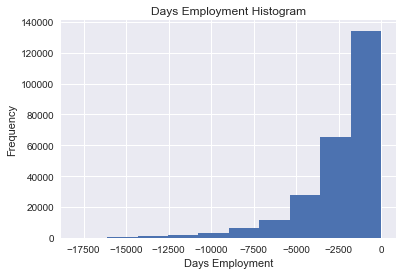

In [13]:
# Replacing non-nom values to NA and assign two new variable to differienciate non-normal vs normal.
app_train['DAYS_EMPLOYED_N_NOM'] = app_train['DAYS_EMPLOYED'] == 365243
app_train['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')
print(f"{len(app_train)} total entry")
print(f"{len(non_nom)} non-norm")

In [14]:
# Analyze Coorelations

correlations = app_train.corr()['TARGET'].sort_values()

# displaying the correlations 

print (f"positive correlation{correlations.tail(5)}")
print (f"negative correlation{correlations.head(5)}")

positive correlationREGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64
negative correlationEXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
Name: TARGET, dtype: float64


-0.07823930830982709


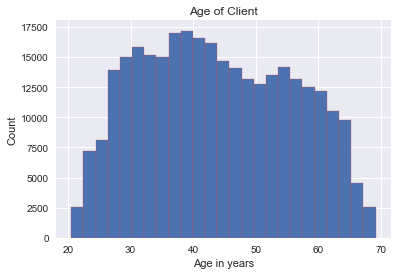

In [15]:
# DAYS_BIRTHS has the highest positive correlations score
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
print(app_train['DAYS_BIRTH'].corr(app_train['TARGET']))
plt.hist(app_train['DAYS_BIRTH']/365, edgecolor = 'r', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age in years');
plt.ylabel('Count');

People whose age are below 40s have higer risk to default.

Text(0.5,1,'Age Distribution')

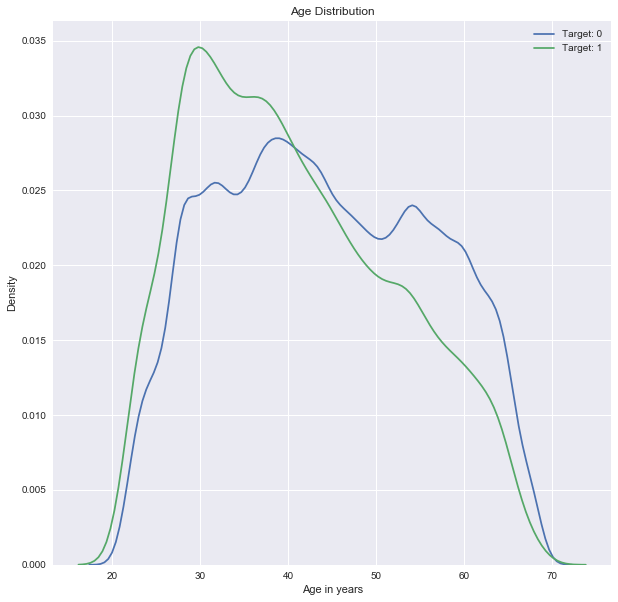

In [16]:
plt.figure(figsize = (10, 10))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH']/365,label = 'Target: 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH']/365,label = 'Target: 1')
plt.xlabel('Age in years'); plt.ylabel('Density'); plt.title('Age Distribution')

the chart above shows that young generation especially at 20-30, have high chance to default replay loan. Now we set 2 years range to analysis the average of fail every two year.

In [17]:
# Set 2 years range to analysis 20-70s people's default chance.
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365
# making age categories
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70, num = 26))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(24.0, 26.0]"
1,0,16765,45.931507,"(44.0, 46.0]"
2,0,19046,52.180822,"(52.0, 54.0]"
3,0,19005,52.068493,"(52.0, 54.0]"
4,0,19932,54.608219,"(54.0, 56.0]"
5,0,16941,46.413699,"(46.0, 48.0]"
6,0,13778,37.747945,"(36.0, 38.0]"
7,0,18850,51.643836,"(50.0, 52.0]"
8,0,20099,55.065753,"(54.0, 56.0]"
9,0,14469,39.641096,"(38.0, 40.0]"


In [18]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 22.0]",0.113312,7846.982567,21.498582
"(22.0, 24.0]",0.131922,8425.124195,23.082532
"(24.0, 26.0]",0.105543,9133.629052,25.023641
"(26.0, 28.0]",0.113922,9914.086630,27.161881
"(28.0, 30.0]",0.112120,10582.182051,28.992280
"(30.0, 32.0]",0.108475,11324.765938,31.026756
"(32.0, 34.0]",0.098246,12042.948285,32.994379
"(34.0, 36.0]",0.097640,12778.407806,35.009336
"(36.0, 38.0]",0.092130,13509.500488,37.012330


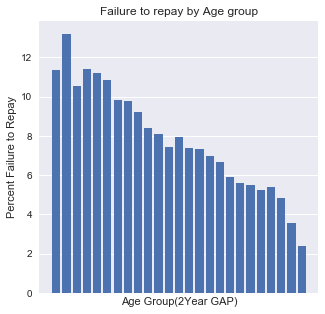

In [19]:
# create plot based on age group
plt.figure(figsize = (5,5)) 
plt.bar(age_groups.index.astype(str), 100*age_groups['TARGET'])
plt.xlabel('Age Group(2Year GAP)');
plt.ylabel('Percent Failure to Repay')
plt.xticks([])
plt.title('Failure to repay by Age group');

Text(0.5,1,'EMPLOYEEMENT Distribution')

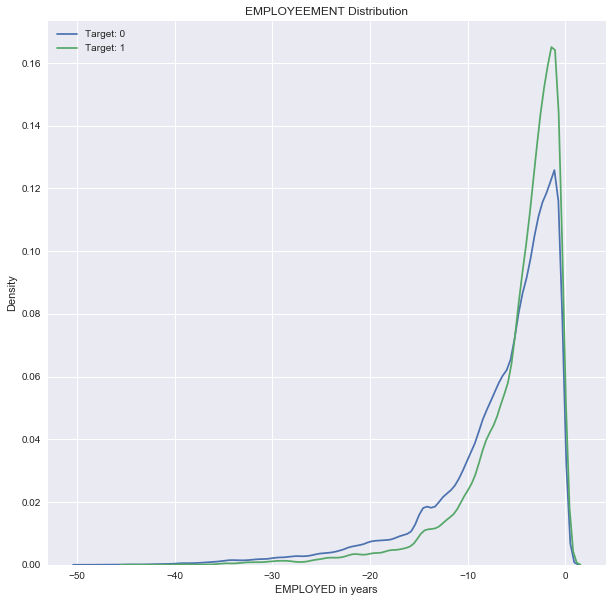

In [20]:
# EMPLOYEMENT
plt.figure(figsize = (10, 10))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_EMPLOYED']/365,label = 'Target: 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_EMPLOYED']/365,label = 'Target: 1')
plt.xlabel('EMPLOYED in years'); plt.ylabel('Density'); plt.title('EMPLOYEEMENT Distribution')

The chart shows people who has less 10 years employed are risker.

In [21]:
# Set 5 years range to analysis years of work default chance
employed_data = app_train[['TARGET', 'DAYS_EMPLOYED']]
employed_data['YEAR_EMPLOYED'] = abs(employed_data['DAYS_EMPLOYED']/365)
employed_data['YEAR_EMPLOYED']=employed_data['YEAR_EMPLOYED'].round(0)
employed_data['YEARS_BINNED'] = pd.cut(employed_data['YEAR_EMPLOYED'], bins = np.linspace(0,49, num = 11))
employed_data.head(10)

,TARGET,DAYS_EMPLOYED,YEAR_EMPLOYED,YEARS_BINNED
0,1,-637.0,2.0,"(0.0, 4.9]"
1,0,-1188.0,3.0,"(0.0, 4.9]"
2,0,-225.0,1.0,"(0.0, 4.9]"
3,0,-3039.0,8.0,"(4.9, 9.8]"
4,0,-3038.0,8.0,"(4.9, 9.8]"
5,0,-1588.0,4.0,"(0.0, 4.9]"
6,0,-3130.0,9.0,"(4.9, 9.8]"
7,0,-449.0,1.0,"(0.0, 4.9]"
8,0,NaN,NaN,NaN
9,0,-2019.0,6.0,"(4.9, 9.8]"


In [22]:
employe_groups = employed_data.groupby('YEARS_BINNED').mean()
employe_groups

,TARGET,DAYS_EMPLOYED,YEAR_EMPLOYED
YEARS_BINNED,,,
"(0.0, 4.9]",0.107053,-847.001914,2.334463
"(4.9, 9.8]",0.077076,-2438.046651,6.698134
"(9.8, 14.7]",0.058302,-4258.235669,11.686213
"(14.7, 19.6]",0.049572,-6063.143172,16.627558
"(19.6, 24.5]",0.048528,-7917.864329,21.688415
"(24.5, 29.4]",0.040290,-9787.357101,26.808406
"(29.4, 34.3]",0.041016,-11609.080078,31.804199
"(34.3, 39.2]",0.022556,-13329.849624,36.532760
"(39.2, 44.1]",0.012346,-15085.378601,41.345679


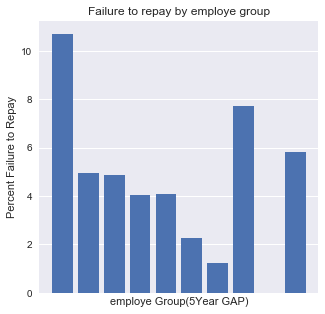

In [23]:
# create plot based on employment group
plt.figure(figsize = (5,5)) 
plt.bar(employe_groups.index.astype(str), 100*employe_groups['TARGET'])
plt.xlabel('employe Group(5Year GAP)');
plt.ylabel('Percent Failure to Repay')
plt.xticks([])
plt.title('Failure to repay by employe group');

People are less than 5 years work are risk, 2nd risk is people who work 40 years

In [24]:
# EXT_SOURCE_3 has the highest negative correlations. 
# However, we do not know the meaning.
ext_data = app_train[['TARGET','EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data.fillna(0)
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.178919,-0.078239
EXT_SOURCE_3,-0.178919,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.205478,1.000000


EXR_SOURCE_3 has negative correlation with Target means people are more like to pay  loans when EXT_SOURCE_3 increase.

Text(0.5,1,'Distribution of Target by EXT_SOURCE_3')

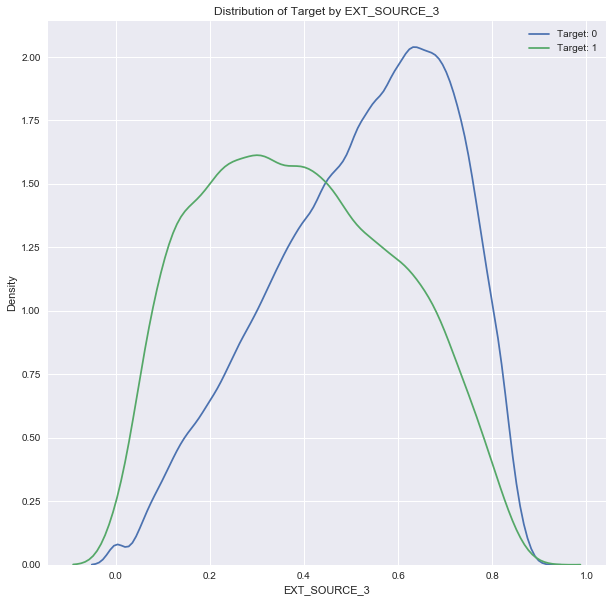

In [25]:
plt.figure(figsize = (10, 10))
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'EXT_SOURCE_3'], label = 'Target: 0')
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'EXT_SOURCE_3'], label = 'Target: 1')
plt.xlabel('EXT_SOURCE_3'); plt.ylabel('Density'); plt.title("Distribution of Target by EXT_SOURCE_3")

the chart above shows that EXT_SOURCE_3 score in especially at 0.6-0.8, people are more likey to pay loans
Now we set 0.25 score range to analyze

In [26]:
EXT_data = app_train[['TARGET', 'EXT_SOURCE_3']]
# making age categories
EXT_data['EXT_SOURCE_3_BINED'] = pd.cut(EXT_data['EXT_SOURCE_3'], bins = np.linspace(0,1.0, num = 5))
EXT_data.head(10)

,TARGET,EXT_SOURCE_3,EXT_SOURCE_3_BINED
0,1,0.139376,"(0.0, 0.25]"
1,0,NaN,NaN
2,0,0.729567,"(0.5, 0.75]"
3,0,NaN,NaN
4,0,NaN,NaN
5,0,0.621226,"(0.5, 0.75]"
6,0,0.492060,"(0.25, 0.5]"
7,0,0.540654,"(0.5, 0.75]"
8,0,0.751724,"(0.75, 1.0]"
9,0,NaN,NaN


In [27]:
EXT_groups = EXT_data.groupby('EXT_SOURCE_3_BINED').mean()
EXT_groups

,TARGET,EXT_SOURCE_3
EXT_SOURCE_3_BINED,,
"(0.0, 0.25]",0.191070,0.160973
"(0.25, 0.5]",0.094359,0.387068
"(0.5, 0.75]",0.046665,0.625815
"(0.75, 1.0]",0.032275,0.792841


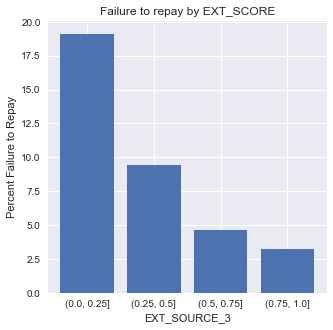

In [28]:
# create plot based on age group
plt.figure(figsize = (5,5)) 
plt.bar(EXT_groups.index.astype(str), 100*EXT_groups['TARGET'])
plt.xlabel('EXT_SOURCE_3');
plt.ylabel('Percent Failure to Repay')
plt.title('Failure to repay by EXT_SCORE');

Above all, the earlier identifier for default is DAYS of Birth and EMPLOYED_DAYS. The range is every 2 years of age and every 5 years of work. If people who are 20-22 and less than 5 years has the highest chance to default. If people has higher 0.75 EXT_SCOURCE_3 Score, hold everything consistance, they has low risk to deafult.